In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary
both vanilla and mlp have big problems in trying to get anywhere near the target. Movement in mean (during run) is very similar.

In [2]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
#     for c in cfgs_flat:
#         c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
#         c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
#     configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df.target_args       = all_df.target_args.astype('str').astype("category")
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../runs

2-dim/


In [4]:
rundir = basedir + "leonhard-runs/2-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-d6a638226f18>:53: UserWarning: Detected NaNs in dataframe. 64 / 199 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [5]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "lr_svgd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg", "target_args"]
f = frame[relevant]
# f

In [6]:
f

,se_mean,se_var,ksd,emd,lr_ksd,lr_svgd,svgd_steps,encoder_layers,ksd_steps,train,lambda_reg,target_args
0,0.760688,12057.398438,0.062758,15.104847,0.030000,49.899891,1,None,NaN,False,NaN,"[array([5.43711132, 5.50653308]), array([[1.16..."
1,20.237015,1.971129,1.409494,6.390849,0.030000,0.330094,1,None,NaN,False,NaN,"[array([5.43711132, 5.50653308]), array([[1.16..."
2,87.594200,5.738799,35.832024,13.328566,0.003525,0.010342,1,"[4, 4, 2]",10.0,True,26.557121,"[array([5.82760352, 7.14073797]), array([[0.64..."
3,26.669622,3.492186,1.003715,7.369835,0.006746,0.029820,1,"[16, 16, 32, 16, 2]",10.0,True,0.006256,"[array([3.75204766, 0.24143274]), array([[4.88..."
4,81.172836,5.782313,33.644005,12.838975,0.001624,0.030662,1,"[4, 4, 2]",10.0,True,0.457509,"[array([5.82760352, 7.14073797]), array([[0.64..."
...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.034448,0.165161,0.027161,0.659119,0.114996,3.752254,1,"[4, 4, 2]",5.0,True,0.000170,"[array([5.43711132, 5.50653308]), array([[1.16..."
195,29.216927,3.741137,10644.704102,7.847752,0.263402,0.039756,1,"[4, 4, 1]",10.0,True,3.197709,"[array([2.82145089, 1.81271222]), array([[4.01..."
196,0.000891,4.407127,0.076099,1.826311,0.030000,5.719802,1,None,NaN,False,NaN,"[array([5.82760352, 7.14073797]), array([[0.64..."
197,3.625554,2.534736,0.346356,2.853993,0.882885,0.594980,1,"[4, 4, 1]",10.0,True,1.388150,"[array([5.43711132, 5.50653308]), array([[1.16..."


# Hyperparameter comparison

## Unfortunately, different targets:

In [7]:
f.target_args = f.target_args.astype("category")

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


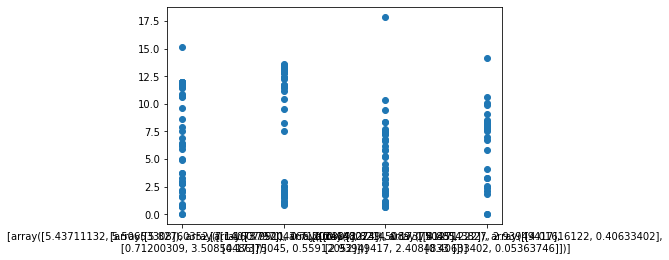

In [8]:
plt.scatter(f.target_args, f.emd)

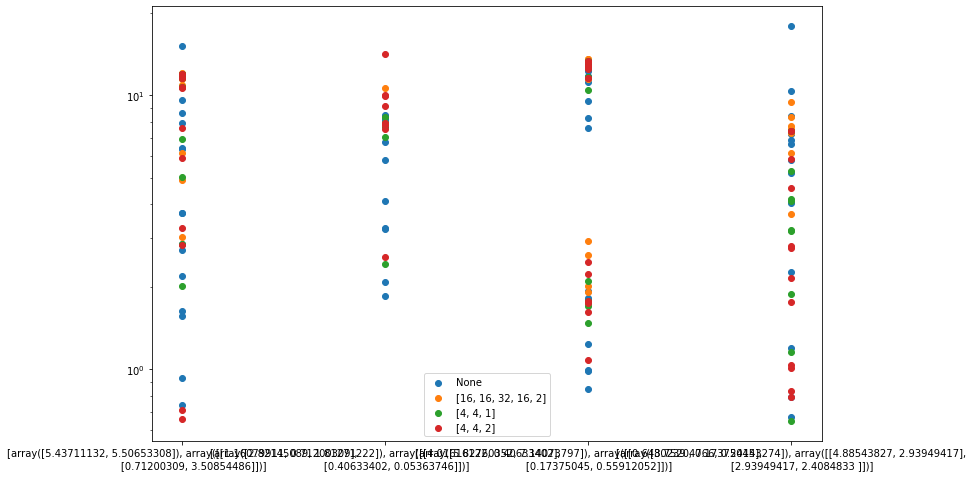

In [9]:
fig, ax = plt.subplots(figsize=[12,8])
groups = f.groupby("encoder_layers")
for name, group in groups:
    ax.scatter(group.target_args, group.emd, marker="o", label=name)
ax.legend()
ax.set_yscale("log")

## Just vanilla

In [10]:
v = frame[f.train == False]
v.target_args = v.target_args.astype(str).astype("object")

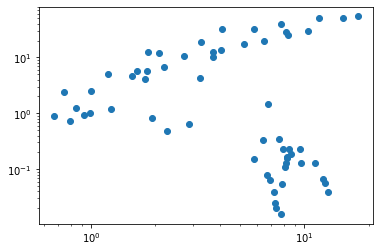

In [11]:
plt.scatter(v.emd, v.lr_svgd)
plt.xscale("log")
plt.yscale("log")

#### The only clear trend seems to be SVGD step size for vanilla:

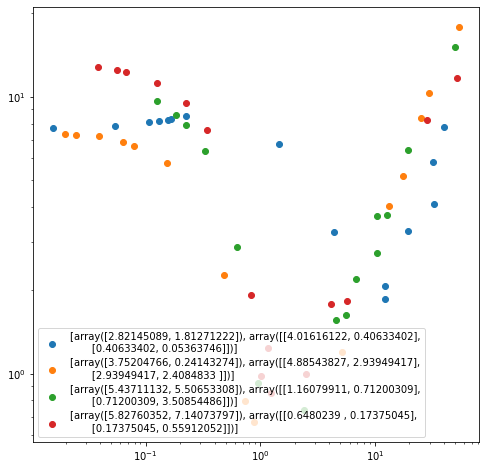

In [12]:
fig, ax = plt.subplots(figsize=[8, 8])
groups = v.groupby("target_args")
for name, group in groups:
    ax.scatter(group.lr_svgd, group.emd, marker="o", label=name)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

## Vanilla + MLP

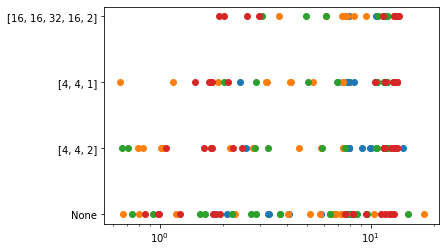

In [13]:
fig, ax = plt.subplots()
groups = f.groupby("target_args")
for name, group in groups:
    ax.scatter(group.emd, group.encoder_layers, marker="o", label=name)
ax.set_xscale("log")
# ax.legend()

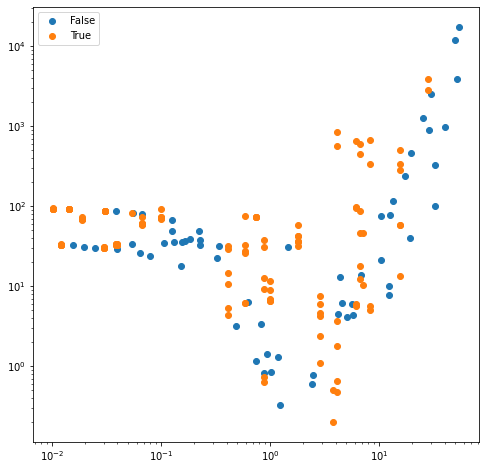

In [14]:
fig, ax = plt.subplots(figsize=[8,8])
groups = f.groupby("train")
for name, group in groups:
    ax.scatter(group.lr_svgd, group.se_mean + group.se_var, marker="o", label=name)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()


In [15]:
print(f.lambda_reg.to_list())

[nan, nan, 26.55712127685547, 0.0062559121288359165, 0.45750880241394043, nan, 0.07591526210308075, nan, 0.07591526210308075, 0.04670219123363495, nan, 0.052264995872974396, 0.0009356100345030427, 7.186443690443411e-05, 0.052264995872974396, 26.55712127685547, 3.197709083557129, nan, 0.00032837732578627765, 0.24870184063911438, nan, 0.24870184063911438, 0.268478661775589, 3.355209264555015e-05, nan, nan, 0.0009356100345030427, 26.55712127685547, 2.8462856789701618e-05, 0.0003974397259298712, nan, 3.197709083557129, nan, 0.004395950585603714, 0.24870184063911438, 9.52919726842083e-05, 0.0003974397259298712, 7.186443690443411e-05, nan, 0.00032837732578627765, 0.43166905641555786, 0.0062559121288359165, nan, 0.004395950585603714, nan, 0.45750880241394043, 0.0062559121288359165, 0.45750880241394043, 23.855226516723633, 0.00032837732578627765, nan, 3.197709083557129, nan, 0.45750880241394043, 1.3881502151489258, 0.000170264407643117, 2.8462856789701618e-05, nan, 0.004309667274355888, nan, 0

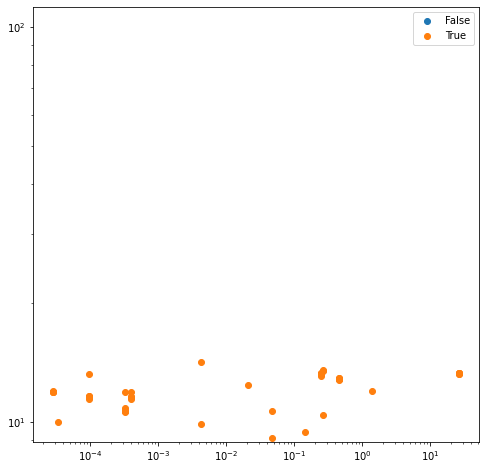

In [16]:
fig, ax = plt.subplots(figsize=[8,8])
groups = f.groupby("train")
for name, group in groups:
    ax.scatter(group.lambda_reg.tolist(), group.emd, marker="o", label=name)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

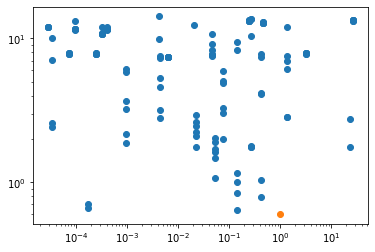

In [17]:
plt.scatter(f.lambda_reg, f.emd)
plt.scatter(1, .6)
plt.xscale("log")
plt.yscale("log")

# Rundata

In [18]:
ind = 2
f.iloc[ind]

se_mean                                                     87.5942
se_var                                                       5.7388
ksd                                                          35.832
emd                                                         13.3286
lr_ksd                                                   0.00352545
lr_svgd                                                   0.0103422
svgd_steps                                                        1
encoder_layers                                            [4, 4, 2]
ksd_steps                                                        10
train                                                          True
lambda_reg                                                  26.5571
target_args       [array([5.82760352, 7.14073797]), array([[0.64...
Name: 2, dtype: object

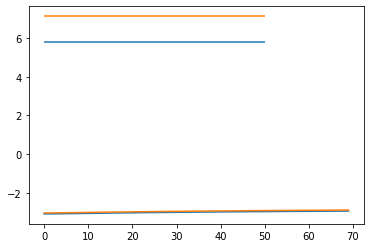

In [19]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

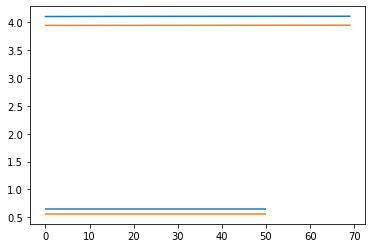

In [20]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)

### KSD

In [21]:
n_iter = 200

In [22]:
ind = 2

In [23]:
frame.iloc[2]

emd                                                                     13.3286
ksd                                                                      35.832
se_mean                                                                 87.5942
se_var                                                                   5.7388
decoder_layers                                                        [2, 4, 2]
encoder_layers                                                        [4, 4, 2]
kernel                                                                      ard
lr_svgd                                                               0.0103422
minimize_ksd_variance                                                      True
n_particles                                                                6000
n_subsamples                                                                100
optimizer_svgd                                                          Adagrad
subsample_with_replacement              

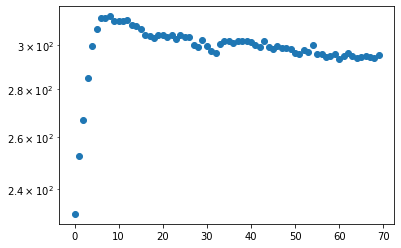

In [24]:
plt.plot(onp.array(rundata[ind]["ksd_after_svgd_update"]), "o", label="KSD after svgd update")
plt.yscale("log")

KeyError: 'ksd_after_kernel_update'

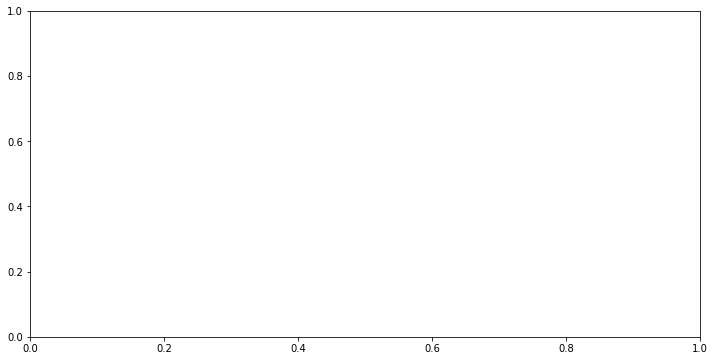

In [25]:
fig, ax = plt.subplots(figsize=[12, 6])
# idx = onp.arange(len(onp.array(rundata[ind]["ksd_after_kernel_update"])))
ax.plot(onp.array(rundata[ind]["ksd_after_kernel_update"]), "o", label="KSD after kernel update")

# ax.legend()
ax.set_yscale("log")

In [ ]:
f